In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV,  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re


from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier



import matplotlib.pyplot as plt


In [4]:
df_selftext = pd.read_csv('../../data/cleaned_selftext.csv')
df_notext = pd.read_csv('../../data/cleaned_notext.csv')
df_selftext.head(2)

,subreddit,text
0,0,using electric water boiler to mine bitcoin th...
1,0,btc to usdt hello i am looking to swap a good ...


In [5]:
print(df_selftext.subreddit.value_counts())
df_notext.subreddit.value_counts()

0    4017
1     787
Name: subreddit, dtype: int64


0    9938
1    2059
Name: subreddit, dtype: int64

# Adding stop words to not make it too easy

In [6]:
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik'.split())


# Model

In [7]:
X = df_selftext.text
y = df_selftext.subreddit

In [8]:
y.value_counts(normalize=True)

0    0.836178
1    0.163822
Name: subreddit, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [10]:
# Hyperparams from individual model opt
nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop, ngram_range = (1, 2),max_features = 775)),
    ('nb', MultinomialNB(alpha = 0.01))
])



knn_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('tvec', TfidfVectorizer(stop_words=stop, ngram_range = (2,3),max_features = 400)),
        ('knn', KNeighborsClassifier(n_neighbors = 12))
])


gb_pipe = Pipeline([
        ('tvec', TfidfVectorizer(stop_words=stop)),
        ('gb', GradientBoostingClassifier(n_estimators = 150, max_features = 60))
])


logr_pipe = Pipeline([
        ('tvec', TfidfVectorizer(stop_words=stop)),
        ('logr', LogisticRegression())
])

In [11]:
stack_estimators = [
    ('nb_pipe', nb_pipe),
#    ('knn_pipe', knn_pipe),
    ('gb_pipe', gb_pipe),
    ('logr_pipe', logr_pipe)   
]

stack = StackingClassifier(estimators=stack_estimators, final_estimator=LogisticRegression())

cross_val_score(stack, X_train, y_train).mean()


0.9039655570966252

In [12]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('nb_pipe',
                                Pipeline(steps=[('tvec',
                                                 TfidfVectorizer(max_features=775,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 stop_words=['i',
                                                                             'me',
                                                                             'my',
                                                                             'myself',
                                                                             'we',
                                                                             'our',
                                                                             'ours',
                                                                   

In [13]:
print(stack.score(X_train, y_train))
stack.score(X_test, y_test)

0.9417152373022482


0.9125728559533722

In [14]:
preds = stack.predict(X_test)

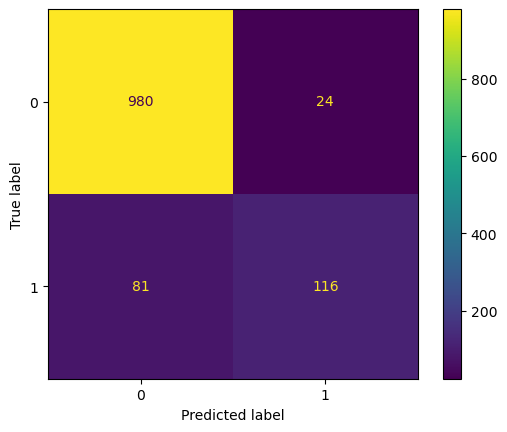

In [15]:
cm = confusion_matrix(y_test, preds)

display = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = stack.classes_)

display.plot();

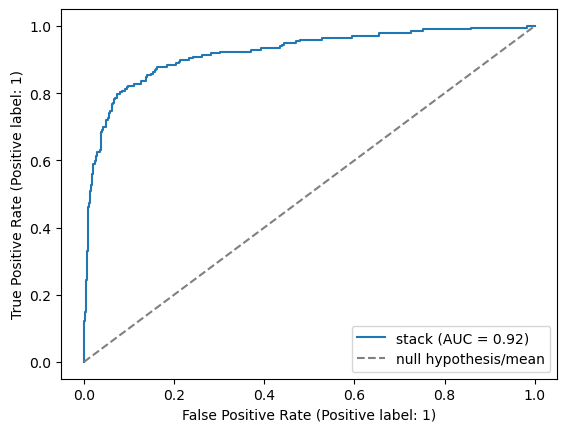

In [16]:
# Basic ROC

# cf ROC
# create an ax object
ax = plt.gca()

# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(stack, X_test, y_test, ax=ax, name='stack')

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

# necessary to label the baseline
plt.legend();

In [17]:
pred_df = pd.DataFrame(stack.predict_proba(X_test),columns=['bitcoin', 'ethereum'])

pred_df['true_values'] = y_test.values

pred_df.head()


,bitcoin,ethereum,true_values
0,0.941171,0.058829,0
1,0.404770,0.595230,1
2,0.939135,0.060865,0
3,0.942827,0.057173,0
4,0.960477,0.039523,0


# False postitives

In [18]:
ethish_indexes = pred_df.loc[(pred_df['ethereum'] > .5) & (pred_df.true_values == 0)].index.values.astype(int)

In [19]:
for i in df_selftext.iloc[ethish_indexes].text:
    print(i,'\n')

btc price during chinese new year doe anybody remember if chinese new year holiday ha affected bitcoin in the past a lot of money are changing hand during this time and i am wondering if this ha caused any uptrend in the past curious to hear your opinion 

not your key not your coin forbes article on binance's asset value loss in the last day are we about to see another major crash like the ftx affair i know a lot of bitcoiners are not really into mainstream medium narrati but what are your thought about the entuality of binance becoming the next ftx basing on this instigation by forbes s 

sold after keeping it for year before the price raise ended up sleeping in my car for a bit and really needed the money it wasn't much but it still hurt that i kept it for so long highest value i got to wa dollar that's a lot for me but had to pull out when it wa only worth suck but this is the end for me and i wish eryone else luck i t ha the fund to pour into bitcoin and it feel pointless anyways 

In [20]:
#notes
def class_from_prob(probabilities, threshold):

    return [0 if prob < threshold else 1 for prob in probabilities]


In [21]:
threshold_list = [round(i*.01,2) for i in range(0,101,)]
speclist = []
senslist = []
f1list = []

for threshold in threshold_list:
    predicted_classes = class_from_prob(pred_df['bitcoin'], threshold)
    spec = specificity_score(y_test, predicted_classes)
    sens = recall_score(y_test, predicted_classes, pos_label=1)
    speclist.append(spec)
    senslist.append(sens)
    F1 = f1_score(y_test, predicted_classes)
    f1list.append(F1)

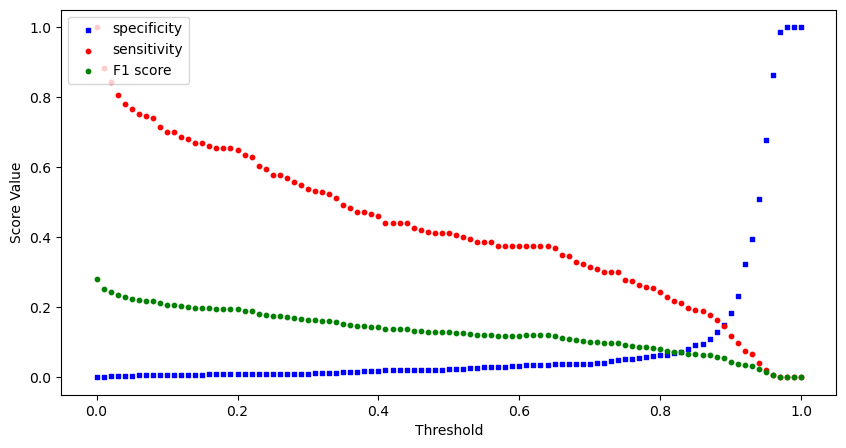

<Figure size 640x480 with 0 Axes>

In [22]:
%matplotlib inline
fig = plt.figure(figsize = (10,5));
ax1 = fig.add_subplot(111);

ax1.scatter(x = threshold_list, y = speclist, s=10, c='b', marker="s", label='specificity');
ax1.scatter(x = threshold_list,y = senslist, s=10, c='r', marker="o", label='sensitivity');
ax1.scatter(x = threshold_list,y = f1list, s=10, c='g', marker="o", label='F1 score');
plt.legend(loc='upper left')
plt.xlabel('Threshold');
plt.ylabel('Score Value');
plt.show();
plt.tight_layout();
